<a href="https://colab.research.google.com/github/DorSkoler/BigData/blob/main/oldplots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -O ./spark-3.3.1-bin-hadoop3.tgz  https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
!tar zxvf ./spark-3.3.1-bin-hadoop3.tgz
!pip install findspark

--2023-01-15 16:35:56--  https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299350810 (285M) [application/x-gzip]
Saving to: ‘./spark-3.3.1-bin-hadoop3.tgz’

./spark-3.3.1-bin-h 100%[===================>] 285.48M   170MB/s    in 1.7s    

2023-01-15 16:35:57 (170 MB/s) - ‘./spark-3.3.1-bin-hadoop3.tgz’ saved [299350810/299350810]

spark-3.3.1-bin-hadoop3/
spark-3.3.1-bin-hadoop3/LICENSE
spark-3.3.1-bin-hadoop3/NOTICE
spark-3.3.1-bin-hadoop3/R/
spark-3.3.1-bin-hadoop3/R/lib/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/DESCRIPTION
spark-3.3.1-bin-hadoop3/R/lib/SparkR/INDEX
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/Rd.rds
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/features.rds
spark-3

In [ ]:
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"

In [ ]:
import findspark
import random
findspark.init()

In [ ]:
# Other imports
import numpy as np
import pyspark
from pyspark.rdd import RDD
from pyspark import SparkContext
from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from numpy.lib.function_base import average

In [ ]:
spark = SparkSession \
    .builder \
    .appName("house-prices") \
    .getOrCreate()

In [ ]:
zhvi_df = spark.read.csv('/content/City_zhvi_month.csv', multiLine=True, inferSchema=True, header=True)
zori_df = spark.read.csv('/content/City_zori_month.csv', multiLine=True, inferSchema=True, header=True)

In [ ]:


oldColumns = zori_df.schema.names
newColumns = zori_df.schema.names[0:8] + ['rent_' + x for x in zori_df.schema.names[8:]]

zori_df = reduce(lambda data, idx: data.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), zori_df)
zori_df.printSchema()
zori_df.show()

root
 |-- RegionID: integer (nullable = true)
 |-- SizeRank: integer (nullable = true)
 |-- RegionName: string (nullable = true)
 |-- RegionType: string (nullable = true)
 |-- StateName: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Metro: string (nullable = true)
 |-- CountyName: string (nullable = true)
 |-- rent_2015-03-31: double (nullable = true)
 |-- rent_2015-04-30: double (nullable = true)
 |-- rent_2015-05-31: double (nullable = true)
 |-- rent_2015-06-30: double (nullable = true)
 |-- rent_2015-07-31: double (nullable = true)
 |-- rent_2015-08-31: double (nullable = true)
 |-- rent_2015-09-30: double (nullable = true)
 |-- rent_2015-10-31: double (nullable = true)
 |-- rent_2015-11-30: double (nullable = true)
 |-- rent_2015-12-31: double (nullable = true)
 |-- rent_2016-01-31: double (nullable = true)
 |-- rent_2016-02-29: double (nullable = true)
 |-- rent_2016-03-31: double (nullable = true)
 |-- rent_2016-04-30: double (nullable = true)
 |-- rent_2016

In [ ]:
newDF = zhvi_df.join(zori_df,zhvi_df.RegionID ==  zori_df.RegionID,"inner")

In [ ]:
newDF.show(20)

+--------+--------+-------------+----------+---------+-----+--------------------+--------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-------

In [ ]:
def plot_this(x, y):
  sns.lineplot(y=y, x=x)
  plt.show()

In [ ]:
fields_zori = []
for x in zori_df.schema[8:]:
  fields_zori.append(x.name)
len(fields_zori)

93

In [ ]:
fields_zhvi = []
for x in fields_zori:
  y = x.replace('rent_', '')
  fields_zhvi.append(y)
len(fields_zhvi)

93

In [ ]:
def monthlyYield(houseValue, rentValue, houseValueNextMonth):
  if houseValue is None or rentValue is None or houseValueNextMonth is None:
    return 0
  return ((rentValue / houseValue) + (houseValueNextMonth / houseValue))

In [ ]:
def yearlyYield(houseValue, rentValue, houseValueNextMonth):
  if houseValue is None or rentValue is None or houseValueNextMonth is None:
    return 0
  return ((rentValue / houseValue) * 12 + (houseValueNextMonth / houseValue))

In [ ]:

yieldList = {}
avgList = {}
for row in newDF.collect():
  yieldList[row['RegionName']] = []
  for index in range(len(fields_zori) - 1):
    month = monthlyYield(row[fields_zhvi[index]], row[fields_zori[index]], row[fields_zori[index + 1]])
    if month != 0:
      yieldList[row['RegionName']].append(round(month * 100, 2))
  avgList[row['RegionName']] = average(yieldList[row['RegionName']])
  print(f"total avg yield - {avgList[row['RegionName']]}%, in - {row['RegionName']}")

total avg yield - 0.8573033707865169%, in - New York
total avg yield - 0.6723913043478261%, in - Los Angeles
total avg yield - 1.4517391304347826%, in - Houston
total avg yield - 1.3066304347826085%, in - Chicago
total avg yield - 1.1518478260869565%, in - San Antonio
total avg yield - 0.9838043478260868%, in - Phoenix
total avg yield - 1.5936956521739132%, in - Philadelphia
total avg yield - 0.9801086956521737%, in - Las Vegas
total avg yield - 0.7107608695652176%, in - San Diego
total avg yield - 1.3219565217391303%, in - Dallas
total avg yield - 0.7425274725274726%, in - Austin
total avg yield - 0.5494565217391304%, in - San Jose
total avg yield - 1.273370786516854%, in - Jacksonville
total avg yield - 1.0927173913043478%, in - Charlotte
total avg yield - 0.5166666666666666%, in - San Francisco
total avg yield - 1.3366304347826088%, in - Indianapolis
total avg yield - 1.3370652173913042%, in - Fort Worth
total avg yield - 1.06%, in - Tucson
total avg yield - 1.3845652173913043%, in 

/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


total avg yield - 0.9967391304347825%, in - Manchester
total avg yield - 0.5712121212121212%, in - Downey
total avg yield - 0.9121739130434783%, in - Asheville
total avg yield - 1.2826086956521738%, in - North Charleston
total avg yield - 0.6172826086956521%, in - Franklin
total avg yield - 1.0125000000000004%, in - Lowell
total avg yield - 0.5540217391304346%, in - Carlsbad
total avg yield - 0.7374999999999999%, in - Centennial
total avg yield - 0.878913043478261%, in - Meridian
total avg yield - 0.7894936708860759%, in - Redding
total avg yield - 1.4825274725274724%, in - Greenville
total avg yield - 1.5638888888888889%, in - High Point
total avg yield - 0.9820652173913043%, in - New Braunfels
total avg yield - 0.9500000000000001%, in - Perris
total avg yield - 0.8564130434782607%, in - Fairfield
total avg yield - 0.6577500000000001%, in - San Leandro
total avg yield - 0.730375%, in - West Covina
total avg yield - 1.4651086956521742%, in - Pompano Beach
total avg yield - 0.8455434782

In [ ]:
regionMax = max(avgList, key=avgList.get)
print(regionMax, avgList[regionMax])

Detroit 5.004021739130435


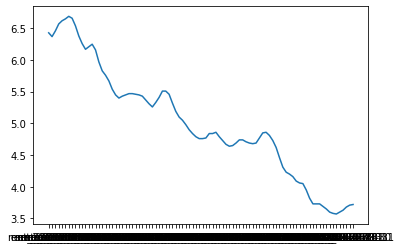

In [ ]:
plot_this(fields_zori[:92],yieldList['Detroit'])

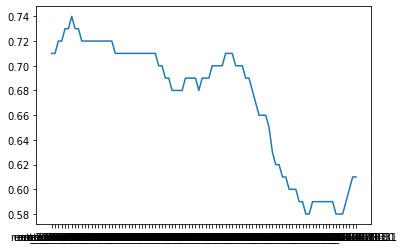

In [ ]:
plot_this(fields_zori[:92],yieldList['Los Angeles'])

In [ ]:
len(yieldList['Detroit'])

92

In [ ]:
avgListWO = filter(lambda x: if x  ,avgList)

In [ ]:
dict(sorted(avgList.items(), key=lambda item: item[1]))

{'Menlo Park': 0.30012658227848105,
 'McLean': 0.3727173913043479,
 'Clayton': 0.41963636363636375,
 'Wahiawa': 0.43625,
 'Pleasanton': 0.45499999999999996,
 'Logan': 0.45999999999999996,
 'San Ramon': 0.46706521739130424,
 'Millcreek': 0.4976,
 'San Gabriel': 0.4993589743589744,
 'Bethesda': 0.5021739130434782,
 'Redondo Beach': 0.5122826086956521,
 'San Francisco': 0.5166666666666666,
 'Castro Valley': 0.5196666666666667,
 'Minot': 0.5242105263157896,
 'New Albany': 0.5276923076923077,
 'Monterey Park': 0.5318181818181819,
 'Louisville': 0.5340677966101696,
 'Seattle': 0.5467391304347825,
 'South San Francisco': 0.5474074074074073,
 'San Jose': 0.5494565217391304,
 'Laguna Niguel': 0.5513043478260868,
 'Shoreline': 0.5534939759036145,
 'Monrovia': 0.5571428571428572,
 'Honolulu': 0.56,
 'Bellflower': 0.5618461538461538,
 'Wooster': 0.5660000000000001,
 'Hacienda Heights': 0.5671428571428572,
 'Washington': 0.5723076923076924,
 'West Haven': 0.5736,
 'Denver': 0.5745454545454546,
 'Ro

In [ ]:
len(avgList)

2275

In [ ]:
zhvi_df_metro = spark.read.csv('/content/Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv', multiLine=True, inferSchema=True, header=True)
zori_df_metro = spark.read.csv('/content/Metro_zori_sm_month.csv', multiLine=True, inferSchema=True, header=True)

In [ ]:
oldColumns = zori_df_metro.schema.names
newColumns = zori_df_metro.schema.names[0:5] + ['rent_' + x for x in zori_df_metro.schema.names[5:]]

zori_df_metro = reduce(lambda data, idx: data.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), zori_df_metro)
zori_df_metro.printSchema()
zori_df_metro.show()

root
 |-- RegionID: integer (nullable = true)
 |-- SizeRank: integer (nullable = true)
 |-- RegionName: string (nullable = true)
 |-- RegionType: string (nullable = true)
 |-- StateName: string (nullable = true)
 |-- rent_2015-03-31: double (nullable = true)
 |-- rent_2015-04-30: double (nullable = true)
 |-- rent_2015-05-31: double (nullable = true)
 |-- rent_2015-06-30: double (nullable = true)
 |-- rent_2015-07-31: double (nullable = true)
 |-- rent_2015-08-31: double (nullable = true)
 |-- rent_2015-09-30: double (nullable = true)
 |-- rent_2015-10-31: double (nullable = true)
 |-- rent_2015-11-30: double (nullable = true)
 |-- rent_2015-12-31: double (nullable = true)
 |-- rent_2016-01-31: double (nullable = true)
 |-- rent_2016-02-29: double (nullable = true)
 |-- rent_2016-03-31: double (nullable = true)
 |-- rent_2016-04-30: double (nullable = true)
 |-- rent_2016-05-31: double (nullable = true)
 |-- rent_2016-06-30: double (nullable = true)
 |-- rent_2016-07-31: double (nullab

In [ ]:
fields_zori_metro = zori_df_metro.schema.names[5:]
len(fields_zori_metro)

93

In [ ]:
newDF_metro = zhvi_df_metro.join(zori_df_metro,zhvi_df_metro.RegionID ==  zori_df_metro.RegionID,"inner")
newDF_metro.show(10)

+--------+--------+----------------+----------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+--------

In [ ]:
yieldList_metro = {}
avgList_metro = {}
for row in newDF_metro.collect():
  yieldList_metro[row['RegionName']] = []
  for index in range(len(fields_zori_metro) - 1):
    month = monthlyYield(row[fields_zori_metro[index].replace('rent_', '')], row[fields_zori_metro[index]], row[fields_zori_metro[index + 1]])
    if month != 0:
      yieldList_metro[row['RegionName']].append(round(month * 100, 2))
  avgList_metro[row['RegionName']] = average(yieldList_metro[row['RegionName']])
  print(f"total avg yield - {avgList_metro[row['RegionName']]}%, in - {row['RegionName']}")

total avg yield - 1.2729347826086954%, in - United States
total avg yield - 1.107191011235955%, in - New York, NY
total avg yield - 0.7039772727272727%, in - Los Angeles, CA
total avg yield - 1.327173913043478%, in - Chicago, IL
total avg yield - 1.136521739130435%, in - Dallas, TX
total avg yield - 1.2681521739130432%, in - Houston, TX
total avg yield - 0.8948913043478259%, in - Washington, DC
total avg yield - 1.2735555555555556%, in - Miami, FL
total avg yield - 1.1771739130434782%, in - Philadelphia, PA
total avg yield - 1.1980434782608698%, in - Atlanta, GA
total avg yield - 0.9457608695652173%, in - Phoenix, AZ
total avg yield - 0.9805617977528088%, in - Boston, MA
total avg yield - 0.5269662921348315%, in - San Francisco, CA
total avg yield - 0.9659782608695651%, in - Riverside, CA
total avg yield - 1.3398913043478262%, in - Detroit, MI
total avg yield - 0.7157608695652175%, in - Seattle, WA
total avg yield - 1.0057608695652176%, in - Minneapolis, MN
total avg yield - 0.74326086

/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



total avg yield - 1.7433333333333334%, in - Fairbanks, AK
total avg yield - 0.7570652173913043%, in - Corvallis, OR
total avg yield - 1.2931578947368423%, in - Clarksburg, WV
total avg yield - nan%, in - Hermiston, OR
total avg yield - nan%, in - Grants Pass, OR
total avg yield - 0.69125%, in - Beaver Dam, WI
total avg yield - 0.985%, in - Zanesville, OH
total avg yield - 0.6301086956521741%, in - Oak Harbor, WA
total avg yield - nan%, in - Russellville, AR
total avg yield - nan%, in - Orangeburg, SC
total avg yield - 0.65625%, in - Watertown, WI
total avg yield - 1.2211290322580644%, in - Columbus, IN
total avg yield - nan%, in - Athens, TX
total avg yield - nan%, in - Indiana, PA
total avg yield - 1.3%, in - Midland, MI
total avg yield - 1.3674444444444445%, in - Hinesville, GA
total avg yield - 0.9052380952380952%, in - Bloomsburg, PA
total avg yield - 1.1472307692307693%, in - Kokomo, IN
total avg yield - 1.26%, in - Elmira, NY
total avg yield - nan%, in - Helena, MT
total avg yie

In [ ]:
regionMax_metro = max(avgList_metro, key=avgList_metro.get)
print(regionMax_metro, avgList_metro[regionMax_metro])

Glenwood Springs, CO 4.044625


In [ ]:
len(fields_zori_metro[12:92])

80

In [ ]:
print(yieldList_metro[regionMax_metro])

[3.53, 3.54, 3.56, 3.64, 3.71, 3.84, 3.92, 3.92, 3.85, 3.79, 3.84, 3.85, 3.81, 3.77, 3.76, 3.79, 3.8, 3.78, 3.76, 3.76, 3.8, 3.78, 3.76, 3.73, 3.75, 3.78, 3.73, 3.69, 3.69, 3.75, 3.81, 3.85, 3.91, 3.95, 3.96, 3.97, 3.99, 4.01, 4.04, 4.04, 3.99, 3.94, 3.96, 4.01, 4.09, 4.16, 4.22, 4.18, 4.15, 4.13, 4.12, 4.1, 4.12, 4.23, 4.37, 4.48, 4.47, 4.41, 4.32, 4.31, 4.34, 4.36, 4.36, 4.35, 4.38, 4.33, 4.23, 4.13, 4.13, 4.19, 4.25, 4.3, 4.48, 4.65, 4.67, 4.53, 4.45, 4.54, 4.5, 4.43]


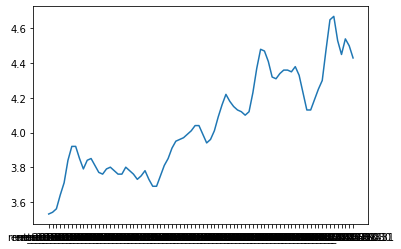

In [ ]:
plot_this(fields_zori_metro[12:92],yieldList_metro[regionMax_metro])